In [1]:
import numpy as np
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from keras.utils import np_utils
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation

Using TensorFlow backend.


# Part 2: CNN on images

# 1,2. load data and extract the bird class

In [2]:
file = 'cifar-10-batches-py/'
trainbatch = ['data_batch_'+str(i) for i in range(1, 6)]
testbatch = 'test_batch'
# training set
data = []
label = []
for path in trainbatch:
    with open(file+path, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        data.extend(batch[b'data'])
        label.extend(batch[b'labels'])
bird_train_id = [i for i,x in enumerate(label) if x==2]        
data = np.array(data)
bird_train = data[bird_train_id]
bird_train = bird_train.reshape(len(bird_train),3,32,32)
bird_train = np.rollaxis(bird_train, 1, 4)
# test set
data = []
label = []
with open(file+testbatch, 'rb') as fo:
    batch = pickle.load(fo, encoding='bytes')
    data.extend(batch[b'data'])
    label.extend(batch[b'labels'])
bird_test_id = [i for i,x in enumerate(label) if x==2]
data = np.array(data)
bird_test = data[bird_test_id]
bird_test = bird_test.reshape(len(bird_test),3,32,32)
bird_test = np.rollaxis(bird_test, 1, 4)
# concatenate training and test set
bird_data = np.concatenate([bird_train, bird_test])
print(bird_data.shape)

(6000, 32, 32, 3)


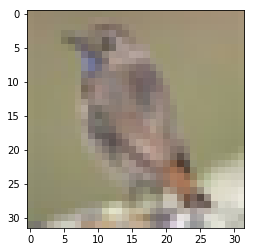

In [3]:
plt.imshow(bird_data[32])
plt.show()

# 3. select at least 10% pixels from dataset

In [4]:
bird_id = np.random.choice(6000, 2000000)
row_id = np.random.choice(32, 2000000)
col_id = np.random.choice(32, 2000000)
pixels = bird_data[bird_id, row_id, col_id,:]

# 4. K-means cluster on these pixels

In [5]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(pixels)
kmeans.cluster_centers_

array([[156.87107042, 156.33880814, 136.79677113],
       [109.67606985, 109.29616743,  83.29605901],
       [ 49.47308738,  50.44641287,  38.87499313],
       [207.4001898 , 212.59436376, 212.2029181 ]])

In [6]:
# use suggested color to represent cluster centers
sug_color = np.array([[0,0,128],
                     [230,25,75],
                     [170,255,195],
                     [55,255,255]])
sug_color

array([[  0,   0, 128],
       [230,  25,  75],
       [170, 255, 195],
       [ 55, 255, 255]])

In [7]:
bird_data_kmeans = bird_data.reshape(-1, bird_data.shape[-1])
for i in range(len(bird_data_kmeans)):
    dis1 = np.linalg.norm(np.array(bird_data_kmeans[i])-kmeans.cluster_centers_[0])
    dis2 = np.linalg.norm(np.array(bird_data_kmeans[i])-kmeans.cluster_centers_[1])
    dis3 = np.linalg.norm(np.array(bird_data_kmeans[i])-kmeans.cluster_centers_[2])
    dis4 = np.linalg.norm(np.array(bird_data_kmeans[i])-kmeans.cluster_centers_[3])
    dis_list = [dis1, dis2, dis3, dis4]
    index = dis_list.index(min(dis_list))
    bird_data_kmeans[i]=sug_color[index]
bird_data_kmeans = np.uint8(bird_data_kmeans.reshape((6000, 32, 32, 3)))

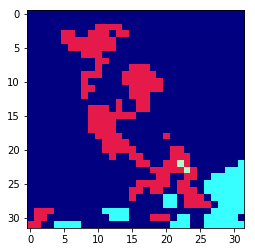

In [8]:
plt.imshow(bird_data_kmeans[32])
plt.show()

# 5. convert imange into grayscale

In [9]:
# using guide form: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html
from skimage.color import rgb2gray
original = bird_data
grayscale = rgb2gray(original)

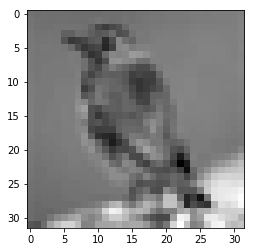

In [10]:
plt.imshow(grayscale[32], cmap=plt.cm.gray)
plt.show()

# 6. CNN to colorrize image

In [11]:
model = Sequential()
# convolutional layer
model.add(Conv2D(32, (5, 5), padding='same',input_shape=(32,32,1)))
model.add(Activation('softmax'))
model.add(Dropout(0.25))
model.add(Conv2D(32, (5, 5)))
model.add(Activation('softmax'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (5, 5), padding='same',input_shape=(32,32,1)))
model.add(Activation('softmax'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# MLP layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4096))
model.add(Activation('softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
__________

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam')
label = kmeans.predict(bird_data.reshape(-1, bird_data.shape[-1]))
# using guide form: https://docs.scipy.org/doc/numpy/reference/generated/numpy.eye.html
label = np.eye(label.max() + 1)[label]
label = label.reshape((6000,4096))
bird_gray = grayscale.reshape((6000,32,32,1))
# select 80% data as training
Xtrain = bird_gray[:4800, :, :, :]
ytrain = label[:4800, :]
Xtest = bird_gray[4800:, :, :, :]
ytest = label[4800:, :]

In [13]:
test_loss = []
class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs={}):
        scores = self.model.evaluate(Xtest, ytest, verbose=1)
        test_loss.append(scores)
        checkpointer = ModelCheckpoint(filepath='CNNcheckpoints\weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

In [14]:
feeding = model.fit(Xtrain, ytrain, validation_split=0.2, batch_size=32, epochs=30, verbose=1, callbacks=[LossHistory()])
total_scores = model.evaluate(Xtest, ytest, verbose=1)

Train on 3840 samples, validate on 960 samples
Epoch 1/30
1200/1200 [==============================] - 0s 185us/step
Epoch 2/30
1200/1200 [==============================] - 0s 177us/step
Epoch 3/30
1200/1200 [==============================] - 0s 173us/step
Epoch 4/30
1200/1200 [==============================] - 0s 175us/step
Epoch 5/30
1200/1200 [==============================] - 0s 177us/step
Epoch 6/30
1200/1200 [==============================] - 0s 165us/step
Epoch 7/30
1200/1200 [==============================] - 0s 175us/step
Epoch 8/30
1200/1200 [==============================] - 0s 184us/step
Epoch 9/30
1200/1200 [==============================] - 0s 172us/step
Epoch 10/30
1200/1200 [==============================] - 0s 174us/step
Epoch 11/30
1200/1200 [==============================] - 0s 176us/step
Epoch 12/30
1200/1200 [==============================] - 0s 167us/step
Epoch 13/30
1200/1200 [==============================] - 0s 175us/step
Epoch 14/30
1200/1200 [================

In [15]:
ypred = model.predict(Xtest)
ypred = ypred.reshape((1200, 32, 32, 4))
ypred = np.argmax(ypred, axis=3)
ypred = sug_color[ypred]
ytest = ytest.reshape((1200, 32, 32, 4))
ytest = np.argmax(ytest, axis=3)

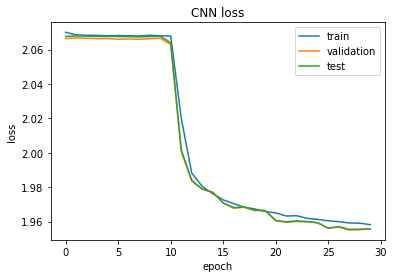

In [16]:
train_loss = feeding.history['loss']
val_loss = feeding.history['val_loss']

plt.plot(train_loss)
plt.plot(val_loss)
plt.plot(test_loss)
plt.title('CNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'])

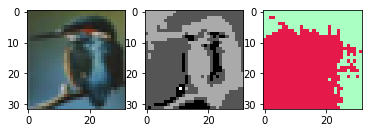

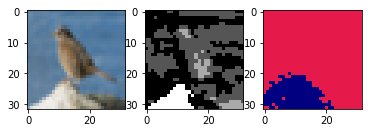

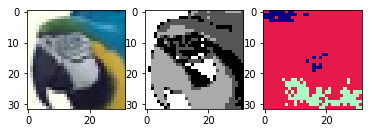

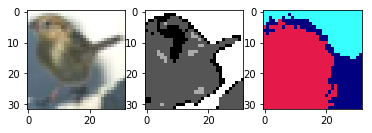

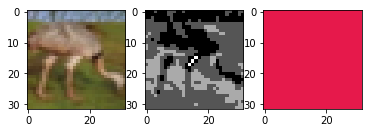

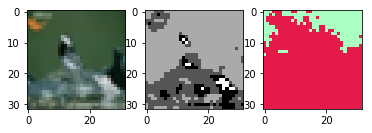

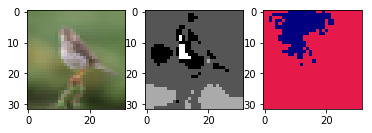

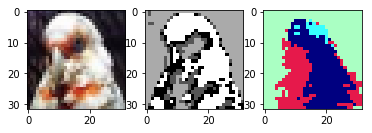

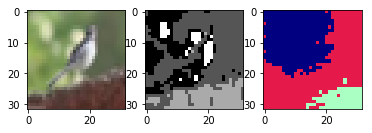

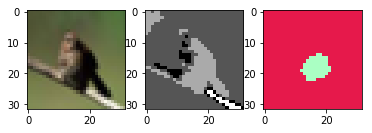

In [17]:
for i in range(0,10):
    figure, image = plt.subplots(1,3)
    image[0].imshow(bird_data[i+4800])
    image[1].imshow(np.uint8(ytest[i]), cmap=plt.cm.gray)
    image[2].imshow(np.uint8(ypred[i]))

In [18]:
print('Test loss:', total_scores)

Test loss: 1.9558021513621013
